# Artificial Neural Network

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf


In [2]:
tf.__version__

'2.9.1'

## Part 1 - Data Preprocessing

### Importing the dataset

In [2]:
dataset = pd.read_excel('Dataset3.xlsx')
dataset.info()

#X=X.to_list()

#y=y.to_list()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Charge_type        546 non-null    object 
 1   Charge_size        546 non-null    float64
 2   Standoff_distance  546 non-null    float64
 3   Incident_pressure  546 non-null    float64
dtypes: float64(3), object(1)
memory usage: 17.2+ KB


In [3]:
# convert categorical variable into dummy variables
dataset = pd.get_dummies(dataset, columns=['Charge_type'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Charge_size        546 non-null    float64
 1   Standoff_distance  546 non-null    float64
 2   Incident_pressure  546 non-null    float64
 3   Charge_type_CompB  546 non-null    uint8  
 4   Charge_type_TNT    546 non-null    uint8  
dtypes: float64(3), uint8(2)
memory usage: 14.0 KB


In [4]:
dataset.head()

,Charge_size,Standoff_distance,Incident_pressure,Charge_type_CompB,Charge_type_TNT
0,0.5,1.5,283.258,0,1
1,0.5,2.5,163.904,0,1
2,0.5,3.5,135.678,0,1
3,0.5,4.5,124.039,0,1
4,0.5,5.5,117.856,0,1


In [5]:
y = dataset['Incident_pressure']
X = dataset.drop('Incident_pressure', axis=1)
print(X.shape, y.shape)

(546, 4) (546,)


In [6]:
# convert to numpy array
X = np.array(X)
y = np.array(y)

### Alternative X and y spliting

In [ ]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

### Encoding categorical data
### Encoding the Independent Variable

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])],
                       remainder='passthrough')
X = np.array(ct.fit_transform(X))

### Splitting the dataset into the Training set and Test set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#X_train=np.asarray(X_train).astype(np.int)

#y_train=np.asarray(y_train).astype(np.int)

In [ ]:
def make_regression_ann(Optimizer_trial):
    from keras.models import Sequential
    from keras.layers import Dense
    
    model = Sequential()
    model.add(Dense(units=5, input_dim=7, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer=Optimizer_trial)
    return model

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
 
# Listing all the parameters to try
Parameter_Trials={'batch_size':[10,20,30],
                      'epochs':[10,20],
                    'Optimizer_trial':['adam', 'rmsprop']
                 }
 
# Creating the regression ANN model
RegModel=KerasRegressor(make_regression_ann, verbose=0)
 
###########################################
from sklearn.metrics import make_scorer
 
# Defining a custom function to calculate accuracy
def Accuracy_Score(orig,pred):
    MAPE = np.mean(100 * (np.abs(orig-pred)/orig))
    print('#'*70,'Accuracy:', 100-MAPE)
    return(100-MAPE)
 
custom_Scoring=make_scorer(Accuracy_Score, greater_is_better=True)
 
#########################################
# Creating the Grid search space
# See different scoring methods by using sklearn.metrics.SCORERS.keys()
grid_search=GridSearchCV(estimator=RegModel, 
                         param_grid=Parameter_Trials, 
                         scoring=custom_Scoring, 
                         cv=5)
 
#########################################
# Measuring how much time it took to find the best params
import time
StartTime=time.time()
 
# Running Grid Search for different paramenters
grid_search.fit(X,y, verbose=1)
 
EndTime=time.time()
print("########## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes')
 
print('### Printing Best parameters ###')
grid_search.best_params_

## Part 2 - Building the ANN

### Initializing the ANN

In [8]:
ann = tf.keras.models.Sequential()

### Adding the input layer and the first hidden layer

In [9]:
ann.add(tf.keras.layers.Dense(units=200, input_shape=(X_train.shape[1],), activation='relu'))

### Adding the second hidden layer

In [10]:
ann.add(tf.keras.layers.Dense(units=100, activation='relu'))

### Adding the third hidden layer

In [11]:
ann.add(tf.keras.layers.Dense(units=50, activation='relu'))

### Adding the output layer

In [12]:
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))

### what model looks like

In [13]:
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               1000      
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 26,201
Trainable params: 26,201
Non-trainable params: 0
_________________________________________________________________


## Part 3 - Training the ANN

### Compiling the ANN

In [14]:
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

### early stopping callback

In [15]:
# protects from unnecessary further training of the model if a particular metric does not continue to improve over a number of n epochs. In such a case, the model training would be automatically aborted.
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=50,
                   restore_best_weights = True)

### Training the ANN model on the Training set

In [16]:
history = ann.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    callbacks=[es],
                    epochs=500,
                    batch_size=50,
                    verbose=1)

Epoch 1/500
9/9 [==============================] - 1s 25ms/step - loss: 1252820.0000 - mae: 422.7809 - val_loss: 538374.7500 - val_mae: 296.0844
Epoch 2/500
9/9 [==============================] - 0s 8ms/step - loss: 1244799.2500 - mae: 411.6830 - val_loss: 530119.6250 - val_mae: 279.6127
Epoch 3/500
9/9 [==============================] - 0s 7ms/step - loss: 1229303.6250 - mae: 388.9014 - val_loss: 515238.7188 - val_mae: 245.8857
Epoch 4/500
9/9 [==============================] - 0s 8ms/step - loss: 1202133.1250 - mae: 348.7765 - val_loss: 493947.0625 - val_mae: 213.8746
Epoch 5/500
9/9 [==============================] - 0s 8ms/step - loss: 1157717.7500 - mae: 342.3401 - val_loss: 476958.8438 - val_mae: 246.1094
Epoch 6/500
9/9 [==============================] - 0s 7ms/step - loss: 1124357.3750 - mae: 384.6028 - val_loss: 468476.6562 - val_mae: 294.1389
Epoch 7/500
9/9 [==============================] - 0s 7ms/step - loss: 1091716.2500 - mae: 421.0252 - val_loss: 463148.0312 - val_mae: 

### Predicting the results of the Test set

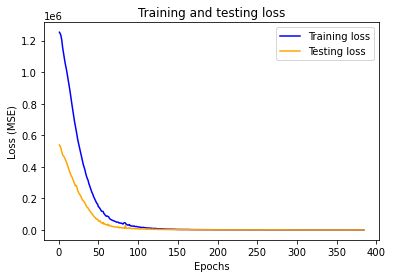

In [17]:
import matplotlib.pyplot as plt
# let's see the training and validation accuracy by epoch
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Testing loss')
plt.title('Training and testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

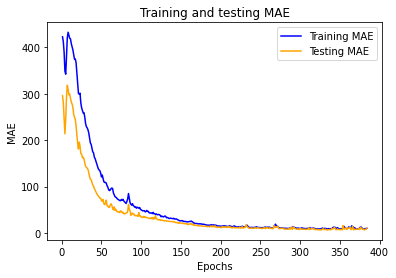

In [18]:
loss_values1 = history_dict['mae'] # you can change this
val_loss_values1 = history_dict['val_mae'] # you can also change this
epochs = range(1, len(loss_values1) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values1, 'blue', label='Training MAE')
plt.plot(epochs, val_loss_values1, 'orange', label='Testing MAE')
plt.title('Training and testing MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [39]:
print (epochs)

range(1, 167)


4/4 [==============================] - 0s 1ms/step


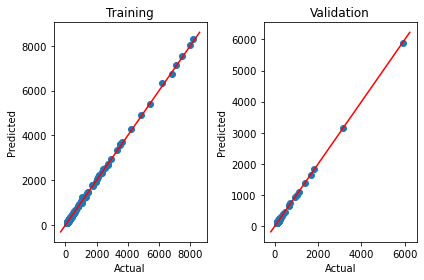

In [19]:
# scatterplot of actual vs. pred
# specify the dimensions 
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
axes[0].scatter(x=y_train, y=ann.predict(X_train)) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_test, y=ann.predict(X_test)) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

In [20]:
#X_test=np.asarray(X_test).astype(np.int)

#y_test=np.asarray(y_test).astype(np.int)

y_pred = ann.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

4/4 [==============================] - 0s 3ms/step
[[ 125.13  126.21]
 [ 137.12  136.68]
 [ 742.99  697.97]
 [ 122.99  120.33]
 [ 923.75  908.62]
 [ 102.71  105.17]
 [ 297.06  292.65]
 [ 114.23  114.76]
 [ 127.89  122.15]
 [ 141.32  149.03]
 [ 142.06  151.21]
 [ 398.14  384.85]
 [ 122.72  122.44]
 [ 101.78  108.02]
 [  99.28  104.34]
 [ 200.77  187.24]
 [ 170.59  180.92]
 [ 148.8   155.65]
 [ 212.83  218.53]
 [ 113.83  110.55]
 [1636.41 1649.83]
 [ 119.8   119.95]
 [ 124.78  120.34]
 [ 113.    107.75]
 [ 654.48  647.73]
 [ 111.58  111.93]
 [ 233.19  242.76]
 [ 117.68  117.74]
 [ 131.93  133.28]
 [ 132.05  135.82]
 [ 232.97  227.9 ]
 [ 165.15  148.37]
 [ 130.52  126.47]
 [ 118.24  116.61]
 [ 108.06  111.98]
 [ 125.08  120.63]
 [ 130.78  125.91]
 [ 130.65  123.56]
 [ 107.94  103.93]
 [ 289.09  305.53]
 [ 118.03  118.49]
 [ 103.2   104.99]
 [ 104.65  103.39]
 [ 104.03  106.75]
 [ 152.14  149.23]
 [ 127.38  130.47]
 [ 136.09  143.94]
 [ 129.15  124.59]
 [ 231.8   216.19]
 [ 105.12  111.05]

Text(0, 0.5, 'Predicted data')

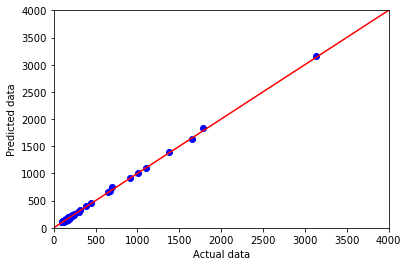

In [21]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, color="blue")
plt.plot ([0,4000],[0,4000], color = "red")
plt.axis ([0,4000,0,4000])
plt.xlabel ('Actual data')
plt.ylabel ('Predicted data')

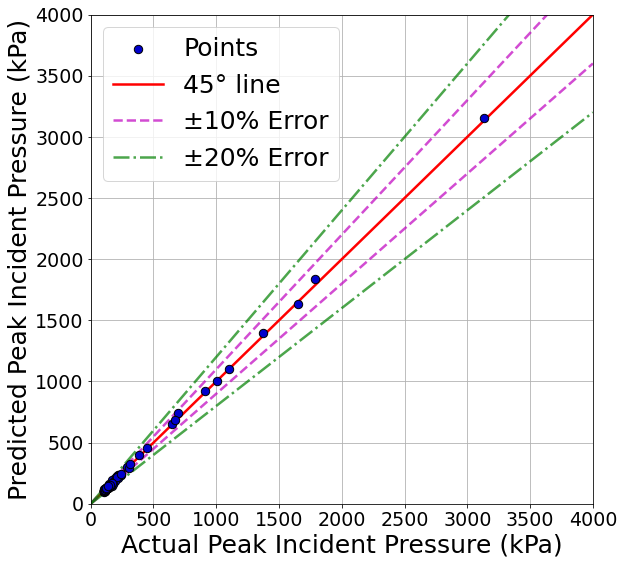

In [22]:
from sklearn.metrics import r2_score
# Initialize layout
fig1, ax1 = plt.subplots(figsize = (9, 9))


#y = y_pred         # Model on prvious line is called here
#x = y_test



# Add scatterplot
ax1.scatter(y_test, y_pred, s=70, alpha=1, edgecolors="k",c='mediumblue',zorder=5, label = 'Points')


plt.ylabel('Predicted Peak Incident Pressure (kPa)',fontsize = 25)
plt.xlabel('Actual Peak Incident Pressure (kPa)',fontsize = 25)
plt.xticks(fontsize = 19)
plt.yticks(fontsize = 19)


x1 = np.linspace(0,4000)

plt.plot(x1, x1, 'Red', label='45\N{DEGREE SIGN} line',lw=2.5,alpha=1)
plt.plot(x1, 1.1*x1, '--m', label='\u00B110% Error',lw=2.5,alpha=0.7)
plt.plot(x1, 0.9*x1,'m', linestyle='--',lw=2.5,alpha=0.7)
plt.plot(x1, 1.2*x1, '-.g', label='\u00B120% Error',lw=2.5,alpha=0.7)
plt.plot(x1, 0.8*x1,'-.g',lw=2.5,alpha=0.7)

plt.ylim(0, 4000)
plt.xlim(0, 4000)
plt.legend(loc='upper left',fontsize = 25)

plt.grid()

ax1.spines['left'].set_color('black')        # setting up Y-axis tick color to red
ax1.spines['bottom'].set_color('black')         #setting up above X-axis tick color to red



#ax1.annotate("$R^2$ = {:.3f}".format(r2), (2500, 1000),fontsize = 25)  #Model is called here
#ax1.annotate("Adj.$R^2$ = {:.3f}".format(adj_r2), (2500, 750),fontsize = 25)

#plt.savefig('plot1.png', dpi = 600, bbox_inches = 'tight')

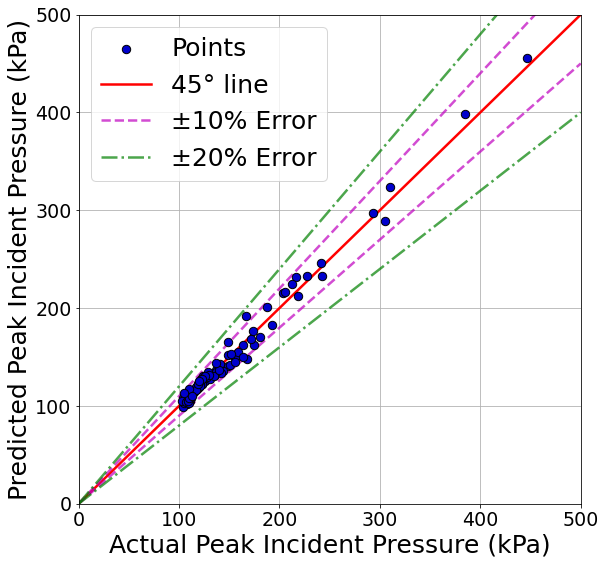

In [23]:
# Initialize layout
fig2, bx = plt.subplots(figsize = (9, 9))



# Add scatterplot
bx.scatter(y_test, y_pred, s=70, alpha=1, edgecolors="k",c='mediumblue',zorder=5, label = 'Points')




plt.ylabel('Predicted Peak Incident Pressure (kPa)',fontsize = 25)
plt.xlabel('Actual Peak Incident Pressure (kPa)',fontsize = 25)
plt.xticks(fontsize = 19)
plt.yticks(fontsize = 19)



x1 = np.linspace(0,500)

plt.plot(x1, x1, 'Red', label='45\N{DEGREE SIGN} line',lw=2.5,alpha=1)
plt.plot(x1, 1.1*x1, '--m', label='\u00B110% Error',lw=2.5,alpha=0.7) #\u00B1
plt.plot(x1, 0.9*x1,'m', linestyle='--',lw=2.5,alpha=0.7)
plt.plot(x1, 1.2*x1, '-.g', label='\u00B120% Error',lw=2.5,alpha=0.7)
plt.plot(x1, 0.8*x1,'-.g',lw=2.5,alpha=0.7)

plt.ylim(0, 500)
plt.xlim(0, 500)
plt.legend(loc='upper left',fontsize = 25)

plt.grid()

bx.spines['left'].set_color('black')        # setting up Y-axis tick color to red
bx.spines['bottom'].set_color('black')         #setting up above X-axis tick color to red


#plt.savefig('plot1.png', dpi = 600, bbox_inches = 'tight')

In [24]:
# metrics


trainpreds = ann.predict(X_train)

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_train, trainpreds)) # train
print(mean_absolute_error(y_test, y_pred)) # test

14/14 [==============================] - 0s 2ms/step
9.550658949265786
6.802162126020948


In [25]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print (r2)

0.999747745837481


In [26]:
r2_train = r2_score(y_train, trainpreds)
print (r2_train)

0.9995899630054741


In [27]:
count1 = 0
for i in range(len(y_pred)):
    line1 = y_pred[i] - 0.9*y_test[i]
    line2 = y_pred[i] - 1.1*y_test[i]
    #print ('line 1 ', line1)
    #print ('line 2 ', line2)
    mask1 = (line1 > 0) & (line2 < 0)
    #print (mask)
    count1 = np.sum(mask1+count1)
    #print (count)

count2 = 0
for j in range(len(y_pred)):
    line3 = y_pred[j] - 0.8*y_test[j]
    line4 = y_pred[j] - 1.2*y_test[j]
    mask2 = (line3 > 0) & (line4 < 0)
    count2 = np.sum(mask2+count2)


count3 = 0    
for k in range(len(y_pred)):
    line5 = y_pred[k] - 0.8*y_test[k]
    line6 = y_pred[k] - 1.2*y_test[k]
    mask3 = (line5 < 0) or (line6 > 0)
    count3 = np.sum(mask3+count3)
   

print ('Within 10% margin', format((count1/len (y_pred)),'.2%'))
print ('Within 20% margin', format((count2/len (y_pred)),'.2%'))
print ('Out of 20% margin', format((count3/len (y_pred)),'.2%'))

Within 10% margin 97.27%
Within 20% margin 100.00%
Out of 20% margin 0.00%


In [28]:
adj_r2 = 1 - ((1 - r2) * (len(X_test) - 1) / (len(X_test) - len (X_test[0]) - 1))
print (adj_r2)

0.9997381361550993


In [29]:
import math
from sklearn.metrics import mean_squared_error

math.sqrt(mean_squared_error(y_test, y_pred))

10.656015386961986

In [30]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, y_pred)

6.802162126020948

In [31]:
from ann_visualizer.visualize import ann_viz;

ann_viz(model, title="My first neural network")

ModuleNotFoundError: No module named 'ann_visualizer'